## 10 Years Yield

/tmp/ipykernel_2015/3394223850.py:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.set_index("date")["y_dec"].resample("M").last().dropna()


=== DETECTED COLUMNS ===
Date column : Date
Yield column: Closing

=== DATA SUMMARY ===
Range: 2016-01-04 to 2025-12-24
Obs  : 2467
Median yield (%): 6.906

=== SHOCK SUMMARY (bps) ===
    horizon  count  p95_up_bps  p99_up_bps  p05_down_bps  p01_down_bps  max_up_bps  max_down_bps
     native   2466        8.50      14.935        -9.075       -14.905        42.6         -49.0
monthly_eom    119       37.41      89.224       -51.930       -64.410       102.0         -73.5

=== WORST WINDOW (bps, monthly) ===
  horizon  worst_up_bps  worst_down_bps
 worst_1m         102.0           -73.5
 worst_3m         124.7          -106.7
 worst_6m         169.5          -133.3
worst_12m         179.6          -167.3


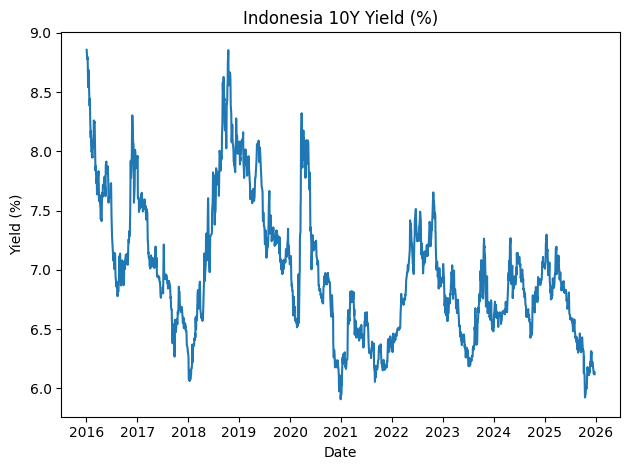

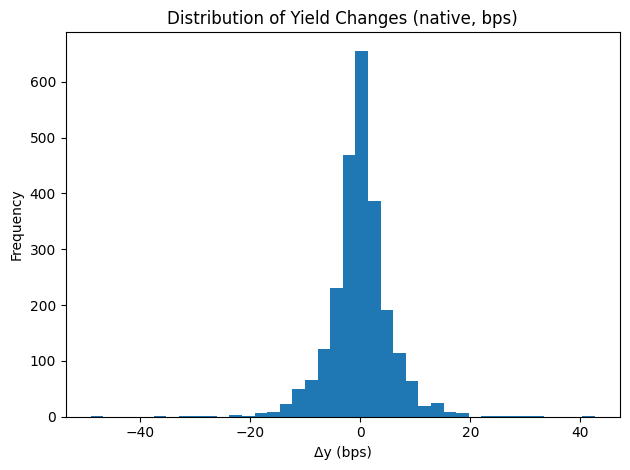

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


FILEPATH = "10 years yield.xlsx"
SHEET = 0  # first sheet; change if needed


# -------------------------
# Helpers
# -------------------------
def detect_date_col(df: pd.DataFrame) -> str:
    keywords = ("date", "tanggal", "time", "periode", "period")
    for c in df.columns:
        if isinstance(c, str) and any(k in c.lower() for k in keywords):
            return c
    # fallback: choose the column with best datetime parse rate
    best_col, best_rate = None, 0
    for c in df.columns:
        parsed = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
        rate = parsed.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a date column. Please set DATE_COL manually.")
    return best_col


def detect_yield_col(df: pd.DataFrame, date_col: str) -> str:
    keywords = ("yield", "imbal", "hasil", "rate", "yld", "suku")
    candidates = [
        c for c in df.columns
        if c != date_col and isinstance(c, str) and any(k in c.lower() for k in keywords)
    ]
    if candidates:
        return candidates[0]
    # fallback: choose most-numeric column excluding date
    best_col, best_rate = None, 0
    for c in df.columns:
        if c == date_col:
            continue
        s = pd.to_numeric(df[c], errors="coerce")
        rate = s.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a yield column. Please set YIELD_COL manually.")
    return best_col


def parse_yield_to_decimal(s: pd.Series) -> pd.Series:
    # handles '7,25', '7.25', '7.25%'
    x = s.astype(str).str.strip()
    x = x.str.replace("%", "", regex=False).str.replace(" ", "", regex=False)
    x = x.str.replace(r"(?<=\d),(?=\d)", ".", regex=True)  # decimal comma -> dot
    y = pd.to_numeric(x, errors="coerce")

    # scale to decimal if it's in percent
    # heuristic: if median > 1, assume percent like 7.25, convert to 0.0725
    if y.dropna().median() > 1:
        y = y / 100.0
    return y


def to_bps(delta_decimal: pd.Series) -> pd.Series:
    # 1 bp = 0.0001 in decimal rate
    return delta_decimal / 0.0001


def shock_table(delta_decimal: pd.Series, label: str) -> pd.DataFrame:
    d = delta_decimal.dropna()
    if d.empty:
        return pd.DataFrame([{
            "horizon": label, "count": 0,
            "p95_up_bps": None, "p99_up_bps": None,
            "p05_down_bps": None, "p01_down_bps": None,
            "max_up_bps": None, "max_down_bps": None
        }])

    return pd.DataFrame([{
        "horizon": label,
        "count": int(d.shape[0]),
        "p95_up_bps": float(to_bps(d.quantile(0.95))),
        "p99_up_bps": float(to_bps(d.quantile(0.99))),
        "p05_down_bps": float(to_bps(d.quantile(0.05))),
        "p01_down_bps": float(to_bps(d.quantile(0.01))),
        "max_up_bps": float(to_bps(d.max())),
        "max_down_bps": float(to_bps(d.min())),
    }])


# -------------------------
# Main processing
# -------------------------
df_raw = pd.read_excel(FILEPATH, sheet_name=SHEET)

DATE_COL = detect_date_col(df_raw)
YIELD_COL = detect_yield_col(df_raw, DATE_COL)

df = df_raw[[DATE_COL, YIELD_COL]].copy()
df.columns = ["date", "y_raw"]

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["y_dec"] = parse_yield_to_decimal(df["y_raw"])  # yield in decimal (e.g., 0.0725)

df = df.dropna(subset=["date", "y_dec"]).sort_values("date").reset_index(drop=True)
df["y_pct"] = df["y_dec"] * 100.0

# Native changes (daily/weekly depending on file)
df["dy_dec"] = df["y_dec"].diff()

# Monthly end-of-month series
m = df.set_index("date")["y_dec"].resample("M").last().dropna()
dm = m.diff()

# Worst k-month window (monthly)
worst_rows = []
for k in [1, 3, 6, 12]:
    dk = m.diff(k).dropna()
    if dk.empty:
        worst_rows.append({"horizon": f"worst_{k}m", "worst_up_bps": None, "worst_down_bps": None})
    else:
        worst_rows.append({
            "horizon": f"worst_{k}m",
            "worst_up_bps": float(to_bps(dk.max())),
            "worst_down_bps": float(to_bps(dk.min()))
        })
worst_df = pd.DataFrame(worst_rows)

# Shock summary tables
native_stats = shock_table(df["dy_dec"], "native")
monthly_stats = shock_table(dm, "monthly_eom")
summary = pd.concat([native_stats, monthly_stats], ignore_index=True)

print("=== DETECTED COLUMNS ===")
print("Date column :", DATE_COL)
print("Yield column:", YIELD_COL)

print("\n=== DATA SUMMARY ===")
print("Range:", df["date"].min().date(), "to", df["date"].max().date())
print("Obs  :", len(df))
print("Median yield (%):", round(df["y_pct"].median(), 4))

print("\n=== SHOCK SUMMARY (bps) ===")
print(summary.to_string(index=False))

print("\n=== WORST WINDOW (bps, monthly) ===")
print(worst_df.to_string(index=False))

# -------------------------
# Outputs (audit trail)
# -------------------------
df_out = df[["date", "y_pct", "y_dec"]].copy()
df_out.to_csv("10y_yield_clean.csv", index=False)
summary.to_csv("10y_yield_shock_summary.csv", index=False)
worst_df.to_csv("10y_yield_worst_windows.csv", index=False)

# -------------------------
# Plots
# -------------------------
plt.figure()
plt.plot(df["date"], df["y_pct"])
plt.title("Indonesia 10Y Yield (%)")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(to_bps(df["dy_dec"].dropna()), bins=40)
plt.title("Distribution of Yield Changes (native, bps)")
plt.xlabel("Δy (bps)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## IHSG 10 Years

=== DETECTED COLUMNS ===
Date column : Date
Index column: Closing

=== DATA SUMMARY ===
Range: 2016-01-04 to 2025-12-29
Obs  : 2417
Last index level: 8644.26

=== SHOCK SUMMARY (returns) ===
            horizon  count p95_up p99_up p05_down p01_down max_up max_down
native_daily_return   2416  1.43%  2.33%   -1.43%   -2.59% 10.19%   -7.90%
 monthly_eom_return    119  5.75%  7.81%   -5.74%  -11.15%  9.44%  -16.76%

=== WORST WINDOW (cumulative return, monthly) ===
window worst_up worst_down
    1M    9.44%    -16.76%
    3M   22.77%    -27.95%
    6M   24.88%    -26.42%
   12M   31.87%    -29.83%


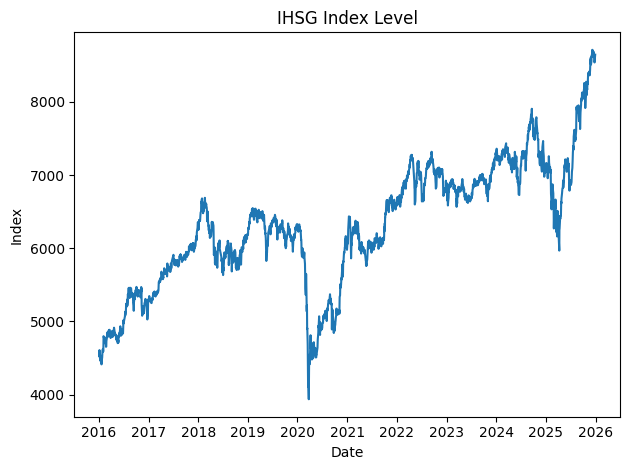

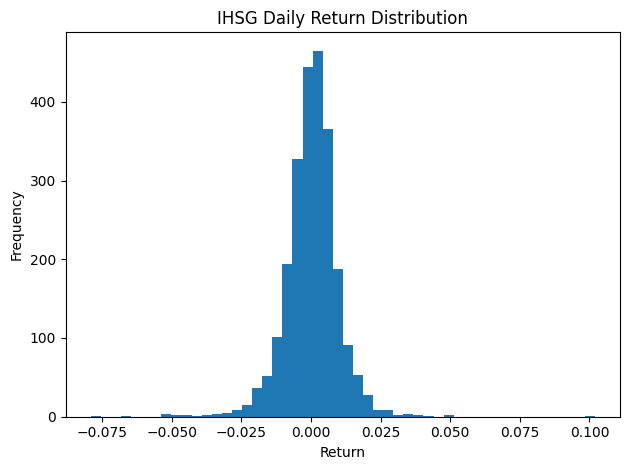


Saved: IHSG_clean.csv, IHSG_shock_summary.csv, IHSG_worst_windows.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

FILEPATH = "IHSG10years.xlsx"   # if in same folder as notebook
SHEET = 0                       # first sheet


# -------------------------
# Helpers (same idea as before)
# -------------------------
def detect_date_col(df: pd.DataFrame) -> str:
    keywords = ("date", "tanggal", "time", "periode", "period")
    for c in df.columns:
        if isinstance(c, str) and any(k in c.lower() for k in keywords):
            return c
    best_col, best_rate = None, 0
    for c in df.columns:
        parsed = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
        rate = parsed.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a date column. Please set DATE_COL manually.")
    return best_col


def detect_price_col(df: pd.DataFrame, date_col: str) -> str:
    keywords = ("close", "closing", "price", "last", "ihsg", "index", "nilai")
    candidates = [
        c for c in df.columns
        if c != date_col and isinstance(c, str) and any(k in c.lower() for k in keywords)
    ]
    if candidates:
        return candidates[0]
    # fallback: most numeric column excluding date
    best_col, best_rate = None, 0
    for c in df.columns:
        if c == date_col:
            continue
        s = pd.to_numeric(df[c], errors="coerce")
        rate = s.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a price/index column. Please set PRICE_COL manually.")
    return best_col


def parse_numeric(series: pd.Series) -> pd.Series:
    x = series.astype(str).str.strip()
    x = x.str.replace(",", "", regex=False)  # remove thousands separators (common)
    x = x.str.replace(" ", "", regex=False)
    return pd.to_numeric(x, errors="coerce")


def shock_table(delta: pd.Series, label: str) -> pd.DataFrame:
    d = delta.dropna()
    if d.empty:
        return pd.DataFrame([{
            "horizon": label, "count": 0,
            "p95_up": None, "p99_up": None,
            "p05_down": None, "p01_down": None,
            "max_up": None, "max_down": None
        }])

    return pd.DataFrame([{
        "horizon": label,
        "count": int(d.shape[0]),
        "p95_up": float(d.quantile(0.95)),
        "p99_up": float(d.quantile(0.99)),
        "p05_down": float(d.quantile(0.05)),
        "p01_down": float(d.quantile(0.01)),
        "max_up": float(d.max()),
        "max_down": float(d.min()),
    }])


def pct(x: float) -> str:
    return f"{100*x:.2f}%"


# -------------------------
# Main
# -------------------------
df_raw = pd.read_excel(FILEPATH, sheet_name=SHEET)

DATE_COL = detect_date_col(df_raw)
PRICE_COL = detect_price_col(df_raw, DATE_COL)

df = df_raw[[DATE_COL, PRICE_COL]].copy()
df.columns = ["date", "px_raw"]

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["px"] = parse_numeric(df["px_raw"])

df = df.dropna(subset=["date", "px"]).sort_values("date").reset_index(drop=True)

# Returns (log return is optional; simple return is usually enough for CP)
df["ret"] = df["px"].pct_change()

# Monthly end-of-month (EOM) prices + returns
m_px = df.set_index("date")["px"].resample("ME").last().dropna()
m_ret = m_px.pct_change()

# Worst k-month window cumulative returns (monthly)
worst_rows = []
for k in [1, 3, 6, 12]:
    cum_ret_k = (m_px / m_px.shift(k)) - 1
    cum_ret_k = cum_ret_k.dropna()
    if cum_ret_k.empty:
        worst_rows.append({"window": f"{k}M", "worst_up": None, "worst_down": None})
    else:
        worst_rows.append({
            "window": f"{k}M",
            "worst_up": float(cum_ret_k.max()),
            "worst_down": float(cum_ret_k.min())
        })
worst_df = pd.DataFrame(worst_rows)

# Shock summaries
native_stats = shock_table(df["ret"], "native_daily_return")
monthly_stats = shock_table(m_ret, "monthly_eom_return")
summary = pd.concat([native_stats, monthly_stats], ignore_index=True)

# Print
print("=== DETECTED COLUMNS ===")
print("Date column :", DATE_COL)
print("Index column:", PRICE_COL)

print("\n=== DATA SUMMARY ===")
print("Range:", df["date"].min().date(), "to", df["date"].max().date())
print("Obs  :", len(df))
print("Last index level:", float(df["px"].iloc[-1]))

print("\n=== SHOCK SUMMARY (returns) ===")
# pretty print as %
summary_fmt = summary.copy()
for c in ["p95_up", "p99_up", "p05_down", "p01_down", "max_up", "max_down"]:
    summary_fmt[c] = summary_fmt[c].apply(lambda v: pct(v) if pd.notna(v) else None)
print(summary_fmt.to_string(index=False))

print("\n=== WORST WINDOW (cumulative return, monthly) ===")
worst_fmt = worst_df.copy()
worst_fmt["worst_up"] = worst_fmt["worst_up"].apply(lambda v: pct(v) if pd.notna(v) else None)
worst_fmt["worst_down"] = worst_fmt["worst_down"].apply(lambda v: pct(v) if pd.notna(v) else None)
print(worst_fmt.to_string(index=False))

# Optional plots
plt.figure()
plt.plot(df["date"], df["px"])
plt.title("IHSG Index Level")
plt.xlabel("Date")
plt.ylabel("Index")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df["ret"].dropna(), bins=50)
plt.title("IHSG Daily Return Distribution")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optional exports (save to current folder)
df[["date", "px", "ret"]].to_csv("IHSG_clean.csv", index=False)
summary.to_csv("IHSG_shock_summary.csv", index=False)
worst_df.to_csv("IHSG_worst_windows.csv", index=False)

print("\nSaved: IHSG_clean.csv, IHSG_shock_summary.csv, IHSG_worst_windows.csv")